<a href="https://colab.research.google.com/github/adag21044/NewsTextProcessor/blob/main/NewsTextVectorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import normalize

In [ ]:
# Download necessary components from NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Load stopwords and lemmatizer
turkish_stopwords = set(stopwords.words('turkish'))
english_stopwords = set(ENGLISH_STOP_WORDS)
lemmatizer = WordNetLemmatizer()

In [ ]:
# Load CSV files
haber_path = "haber.csv"
bbc_news_path = "bbc_news.csv"

haber_df = pd.read_csv(haber_path, encoding='utf-8')
bbc_news_df = pd.read_csv(bbc_news_path, encoding='utf-8')

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
# Preprocessing function without tokenization dependency
def preprocess_text(text, lang="turkish"):
    if pd.isna(text):
        return ""

    text = text.lower()  # Convert text to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    words = text.split()  # Simple whitespace-based tokenization

    if lang == "turkish":
        words = [word for word in words if word not in turkish_stopwords]
    else:
        words = [lemmatizer.lemmatize(word) for word in words if word not in english_stopwords]

    return " ".join(words)

In [ ]:
# Clean Turkish and English news text
haber_df["clean_text"] = haber_df["tweet"].apply(lambda x: preprocess_text(x, lang="turkish"))
bbc_news_df["clean_text"] = (bbc_news_df["title"] + " " + bbc_news_df["description"]).apply(lambda x: preprocess_text(x, lang="english"))

In [ ]:
# TF-IDF Vectorization
# - Calculates term importance using weight adjustments.
# - Uses (1,3) n-gram range to consider single words, bigrams, and trigrams.
# - Sublinear_tf=True ensures that frequent words do not dominate.
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, stop_words='english', sublinear_tf=True)
all_texts = pd.concat([haber_df["clean_text"], bbc_news_df["clean_text"]], axis=0)
tfidf_matrix = tfidf_vectorizer.fit_transform(all_texts)

In [ ]:
# n-gram Vectorization (CountVectorizer)
# - Counts raw occurrences of words and n-grams.
# - Does not weigh words but gives pure frequency counts.
ngram_vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=10000, stop_words='english')
ngram_matrix = ngram_vectorizer.fit_transform(all_texts)

In [ ]:
# Normalize vectors to improve stability
# - L2 normalization ensures consistent magnitude across samples.
tfidf_matrix = normalize(tfidf_matrix, norm='l2', axis=1)
ngram_matrix = normalize(ngram_matrix, norm='l2', axis=1)

In [ ]:
# Compare results
# - TF-IDF highlights important words by reducing the effect of frequent ones.
# - n-gram captures raw word frequencies which can be useful for certain applications.
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
print("n-gram Matrix Shape:", ngram_matrix.shape)

TF-IDF Matrix Shape: (44831, 10000)
n-gram Matrix Shape: (44831, 10000)


In [ ]:
# Extract feature names
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
ngram_feature_names = ngram_vectorizer.get_feature_names_out()

In [ ]:
# Get top 20 TF-IDF features
tfidf_sums = tfidf_matrix.sum(axis=0).A1
top_tfidf_indices = tfidf_sums.argsort()[-20:]
top_tfidf_words = [tfidf_feature_names[i] for i in top_tfidf_indices]
top_tfidf_values = [tfidf_sums[i] for i in top_tfidf_indices]

In [ ]:
# Get top 20 n-gram features
ngram_sums = ngram_matrix.sum(axis=0).A1
top_ngram_indices = ngram_sums.argsort()[-20:]
top_ngram_words = [ngram_feature_names[i] for i in top_ngram_indices]
top_ngram_values = [ngram_sums[i] for i in top_ngram_indices]

<ipython-input-24-80d5edcb6a8d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_tfidf_values, y=top_tfidf_words, palette='viridis')


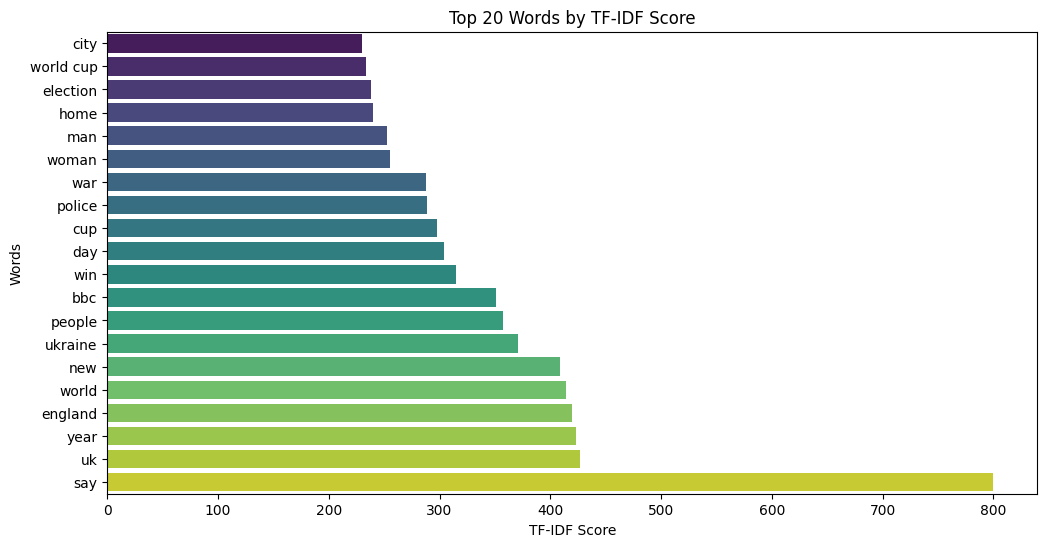

In [ ]:
# Plot TF-IDF feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x=top_tfidf_values, y=top_tfidf_words, palette='viridis')
plt.xlabel("TF-IDF Score")
plt.ylabel("Words")
plt.title("Top 20 Words by TF-IDF Score")
plt.show()

<ipython-input-25-fb0c1b39b755>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_ngram_values, y=top_ngram_words, palette='plasma')


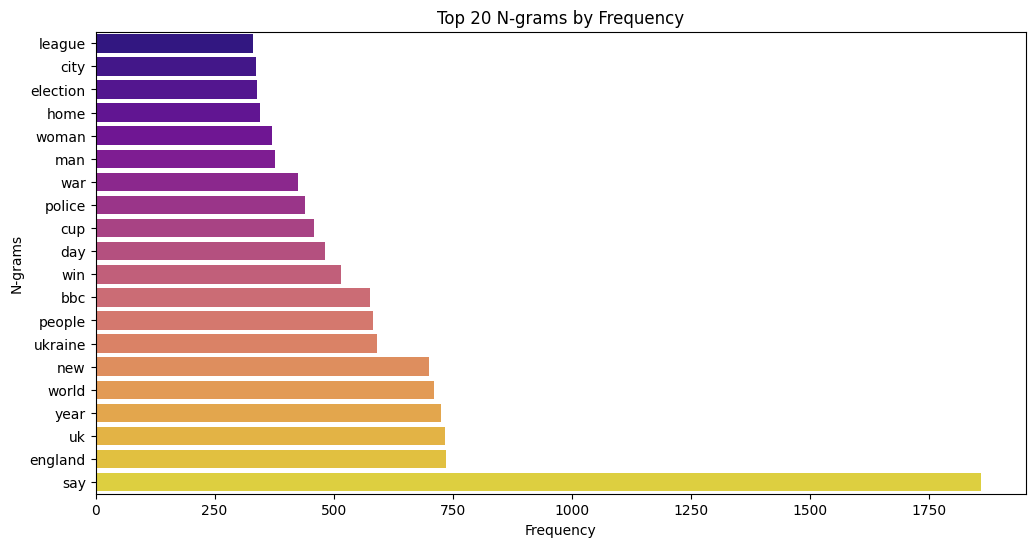

In [ ]:
# Plot n-gram frequency
plt.figure(figsize=(12, 6))
sns.barplot(x=top_ngram_values, y=top_ngram_words, palette='plasma')
plt.xlabel("Frequency")
plt.ylabel("N-grams")
plt.title("Top 20 N-grams by Frequency")
plt.show()


In [ ]:
pip install wordcloud

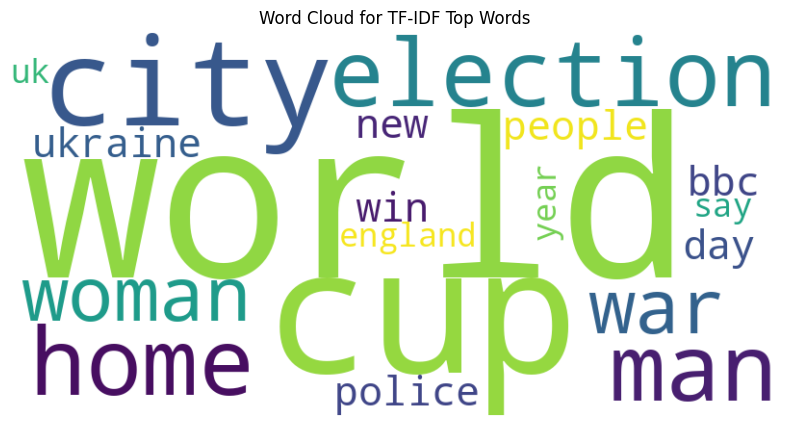

In [ ]:
# Import the WordCloud class
from wordcloud import WordCloud

# Generate word clouds for visualization
wordcloud_tfidf = WordCloud(width=800, height=400, background_color='white').generate(" ".join(top_tfidf_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_tfidf, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for TF-IDF Top Words")
plt.show()

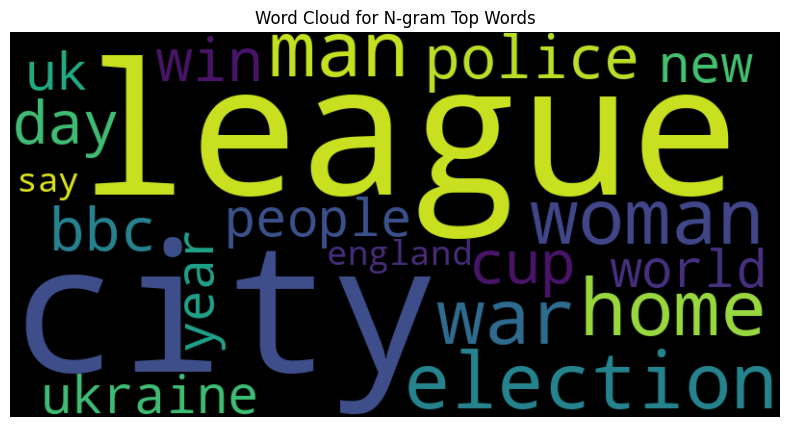

In [ ]:
wordcloud_ngram = WordCloud(width=800, height=400, background_color='black').generate(" ".join(top_ngram_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_ngram, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for N-gram Top Words")
plt.show()
